In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from tqdm import tqdm
import tensorflow_datasets as tfds

tf.get_logger().setLevel('ERROR')

In [2]:
DATASET_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data"
data_file = tf.keras.utils.get_file("breast_cancer.csv", DATASET_URL)
col_names = ["id", "clump_thickness", "un_cell_size", "un_cell_shape", "marginal_adheshion", "single_eph_cell_size", "bare_nuclei", "bland_chromatin", "normal_nucleoli", "mitoses", "class"]
df = pd.read_csv(data_file, names=col_names, header=None)

24576/19889 [=====================================] - 0s 8us/step


In [3]:
df.head()

,id,clump_thickness,un_cell_size,un_cell_shape,marginal_adheshion,single_eph_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [4]:
df.pop("id")

0      1000025
1      1002945
2      1015425
3      1016277
4      1017023
        ...   
694     776715
695     841769
696     888820
697     897471
698     897471
Name: id, Length: 699, dtype: int64

In [5]:
df = df[df["bare_nuclei"] != '?' ]
df.bare_nuclei = pd.to_numeric(df.bare_nuclei)

<AxesSubplot:>

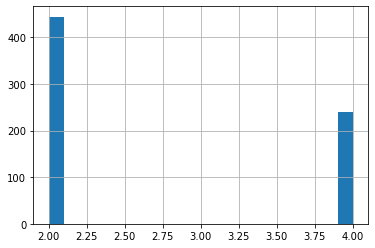

In [6]:
df['class'].hist(bins=20) 

In [7]:
df['class'] = np.where(df['class'] == 2, 0, 1)

In [9]:
train, test = train_test_split(df, test_size = 0.2)

In [10]:
train_stats = train.describe()
train_stats

,clump_thickness,un_cell_size,un_cell_shape,marginal_adheshion,single_eph_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
count,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000
mean,4.521978,3.250916,3.327839,2.891941,3.315018,3.652015,3.525641,2.945055,1.635531,0.364469
std,2.876107,3.151416,3.062744,2.894672,2.288310,3.712583,2.468198,3.115028,1.788070,0.481722
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,0.000000
50%,4.000000,1.000000,2.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,0.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,7.750000,5.000000,4.000000,1.000000,1.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000


In [11]:
train_stats.pop('class')

count    546.000000
mean       0.364469
std        0.481722
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: class, dtype: float64

In [13]:
train_stats = train_stats.T

In [14]:
train_y= train.pop('class')
test_y= test.pop('class')


<AxesSubplot:>

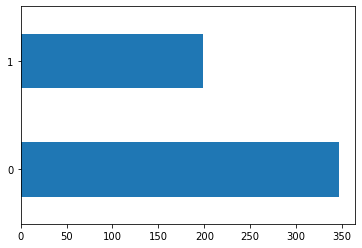

In [17]:
train_y.value_counts().plot.barh()

In [20]:
def normalize(x):
    return (x-train_stats['mean'])/train_stats['std']

In [21]:
norm_train_X = normalize(train)
norm_test_X = normalize(test)

- Now to train a model we need to create dataset 
- then we need to batch them

In [25]:
trn_dataset = tf.data.Dataset.from_tensor_slices((norm_train_X.values, train_y.values))
test_dataset = tf.data.Dataset.from_tensor_slices((norm_test_X.values, test_y.values))

In [27]:
bs = 32
train_dataset = trn_dataset.shuffle(buffer_size= len(train)).batch(bs)
test_dataset = test_dataset.batch(bs)

In [42]:
a = enumerate(train_dataset)

In [43]:
len(list(a))

18

In [45]:
def base_model():
    inputs = tf.keras.layers.Input(shape=(len(train.columns)))

    x = tf.keras.layers.Dense(128, activation='relu')(inputs)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

model = base_model()

In [46]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
loss_object = tf.keras.losses.BinaryCrossentropy()

In [48]:
outputs = model(norm_test_X.values)
loss_value = loss_object(y_true=test_y.values, y_pred=outputs)
print("Loss before training %.4f" % loss_value.numpy())

Loss before training 0.6710


In [55]:
tf.round(outputs)

<tf.Tensor: shape=(137, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
 

In [57]:
cm = confusion_matrix(test_y.values, tf.round(outputs))
cm

array([[77, 20],
       [35,  5]])

In [75]:
def plot_confusion_matrix(y_true, y_pred, title='', labels=[0,1]):
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title(title)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
          plt.text(j, i, format(cm[i, j], fmt),
                  horizontalalignment="center",
                  color="black" if cm[i, j] > thresh else "white")
    plt.show()

<ipython-input-75-b043df30f57b>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
<ipython-input-75-b043df30f57b>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


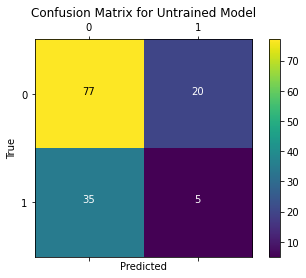

In [76]:
plot_confusion_matrix(test_y.values, tf.round(outputs), title='Confusion Matrix for Untrained Model')

In [82]:
cm = tf.math.confusion_matrix(test_y.values, tf.round(outputs), num_classes=2)
cm

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[77, 20],
       [35,  5]], dtype=int32)>

In [88]:
cm[0][0]

<tf.Tensor: shape=(), dtype=int32, numpy=77>

In [87]:
cm[1][0]

<tf.Tensor: shape=(), dtype=int32, numpy=35>

In [89]:
cm[0][1]

<tf.Tensor: shape=(), dtype=int32, numpy=20>

so we will now create metrics named as `F1 score`. let me think what we need
 1. we will use class
  - that may be needs to be inherited from any tf class, ``tf.keras.metrics.Metric``
 2. initialize, may be name 
 3. we need to create some variables for example we need to true label and prediction. `update_state`
 4. we need to do some calculation for these variables .`result`
 5. finally `reset_states`


point 1 and 2 is done
```python
class F1Metric_(tf.keras.metrics.Metric):
    def __init__(self, name = 'f1Score', **kwargs)
    
    super(F1Metric_, self).__init__(name =name, **kwargs)
 ```

here we have just created some variable, As we created through ``tf.Variable`` we can change those value. So for each batch we can change them and after batch ending we can save them 
```python
self.tp= tf.Variable(0, dtype='int32')
self.tn = tf.Variable(0, dtype='int32')
self.fp = tf.Variable(0, dtype='int32')
self.fn = tf.Variable(0, dtype='int32')
 ```

- Right now we just initialize those varaibles we need actually some value and those value we can get them from some kind of metrics.
- here we are implmenting ``f1 score``. For that we can call confusion metrics and then from that we can get those values.
 ``` python
def update_state(self, y_true, y_pred,sample_weight=None):
    conf_mat = tf.math.confusion_matrix(y_true, y_pred, num_classes = 2)
    self.tn.assign_add(conf_mat[0][0])
    self.tp.assign_add(conf_mat[1][1])
    self.fp.assign_add(conf_mat[0][1])
    self.fn.assign_add(conf_mat[1][0])

 ```

In [94]:
class F1Metric_(tf.keras.metrics.Metric):
    def __init__(self, name = 'f1Score', **kwargs):
    
        super(F1Metric_, self).__init__(name =name, **kwargs)

        self.tp= tf.Variable(0, dtype='int32')
        self.tn = tf.Variable(0, dtype='int32')
        self.fp = tf.Variable(0, dtype='int32')
        self.fn = tf.Variable(0, dtype='int32')

    
    def update_state(self, y_true, y_pred,sample_weight=None):
        conf_mat = tf.math.confusion_matrix(y_true, y_pred, num_classes = 2)
        self.tn.assign_add(conf_mat[0][0])
        self.tp.assign_add(conf_mat[1][1])
        self.fp.assign_add(conf_mat[0][1])
        self.fn.assign_add(conf_mat[1][0])
        
    def result(self):
        '''Computes and returns the metric value tensor.'''

        # Calculate precision
        if (self.tp + self.fp == 0):
            precision = 1.0
        else:
            precision = self.tp / (self.tp + self.fp)
      
        # Calculate recall
        if (self.tp + self.fn == 0):
            recall = 1.0
        else:
            recall = self.tp / (self.tp + self.fn)

        # Return F1 Score
        ### START CODE HERE ###
        f1_score =2* ((precision*recall)/(precision+recall))
        ### END CODE HERE ###
        
        return f1_score
    def reset_state(self):
        self.tp.assign(0)
        self.tn.assign(0)
        self.fp.assign(0)
        self.fn.assign(0)

In [95]:
trn_f1 = F1Metric_()
trn_acc = tf.keras.metrics.BinaryAccuracy()


In [96]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
loss_object = tf.keras.losses.BinaryCrossentropy()

In [107]:
def gradient_cal(model,opt, data, label,loss_object):
    with tf.GradientTape() as tape:
        logits = model(data)
        loss = loss_object(label,logits)
    gradient = tape.gradient(loss,model.trainable_weights)
    opt.apply_gradients(zip(gradient, model.trainable_weights))
    
    return logits, loss

In [128]:
def trian_one_epoch(model,train_data,  opt,loss_object,  trn_acc, trn_f1, verbose = True):
    #train data is a iterator so we need to go through each batch first
    all_loss =[]
    
    for batch, (batch_x, batch_y) in enumerate(train_data):
        
        logits, loss= gradient_cal(model,opt, batch_x, batch_y,loss_object)
        all_loss.append(loss)
        
        #for accuracy we need to process our logits
        logits = tf.round(logits)
        logits = tf.cast(logits, 'int64')
        
        trn_acc.update_state(batch_y, logits)
        trn_f1.update_state(batch_y, logits)
        if verbose:
               print("Training loss for batch %s: %.4f" % (int(batch), float(loss)))
    return all_loss
            

In [129]:
val_metric = tf.keras.metrics.BinaryAccuracy()
val_f1 = F1Metric_()

In [130]:
def perform_validation(test_dataset, model):
    losses = []
    for x_val,label in test_dataset:
        logits = model(x_val)
        loss = loss_object(label, logits)
        losses.append(loss)
        
        val_label = tf.cast(tf.round(logits), 'int64')
        val_metric.update_state(label, val_label)
        val_f1.update_state(label, val_label)
        
    return losses

In [132]:
epochs = 10
epoch_loss = []
epoch_val_loss = []
for i in range(epochs):
    train_loss = trian_one_epoch(model, train_dataset, optimizer, loss_object, trn_acc, trn_f1)
    
    train_acc = trn_acc.result()
    trn_f1_score = trn_f1.result()
    
    print(train_acc, trn_f1_score)
    
    val_loss = perform_validation(test_dataset, model)
    epoch_val_loss.append(np.mean(val_loss))
    
     #print('\n Epcoh %s: Train loss: %.4f  Validation Loss: %.4f, Train Accuracy: %.4f, Validation Accuracy %.4f, Train F1 Score: %.4f, Validation F1 Score: %.4% (epoch, float(losses_train_mean), float(losses_val_mean), float(tr
    
    print(val_metric.result(), val_f1.result())
    
    trn_acc.reset_states()
    trn_f1.reset_states()
    val_metric.reset_states()
    val_f1.reset_states()
    

Training loss for batch 0: 0.0074
Training loss for batch 1: 0.0737
Training loss for batch 2: 0.0780
Training loss for batch 3: 0.0959
Training loss for batch 4: 0.1011
Training loss for batch 5: 0.0554
Training loss for batch 6: 0.0109
Training loss for batch 7: 0.0389
Training loss for batch 8: 0.0148
Training loss for batch 9: 0.0345
Training loss for batch 10: 0.0090
Training loss for batch 11: 0.1159
Training loss for batch 12: 0.0548
Training loss for batch 13: 0.1083
Training loss for batch 14: 0.1477
Training loss for batch 15: 0.0181
Training loss for batch 16: 0.0503
Training loss for batch 17: 0.0006
tf.Tensor(0.9774306, shape=(), dtype=float32) tf.Tensor(0.9633251833740831, shape=(), dtype=float64)
tf.Tensor(0.9625, shape=(), dtype=float32) tf.Tensor(0.9268292682926829, shape=(), dtype=float64)
Training loss for batch 0: 0.0103
Training loss for batch 1: 0.0375
Training loss for batch 2: 0.0613
Training loss for batch 3: 0.0722
Training loss for batch 4: 0.0100
Training lo

<ipython-input-75-b043df30f57b>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
<ipython-input-75-b043df30f57b>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


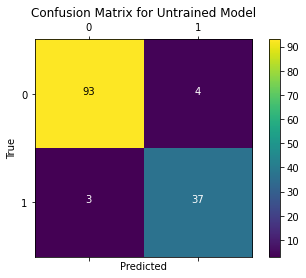

In [134]:
test_outputs = model(norm_test_X.values)
plot_confusion_matrix(test_y.values, tf.round(test_outputs), title='Confusion Matrix for Untrained Model')